In [1]:
base_dir = '/media/bigdata/projects/pytau'
import sys
sys.path.append(base_dir)
from pytau.changepoint_io import FitHandler, DatabaseHandler
from pytau.changepoint_analysis import PklHandler
import pylab as plt
from pytau.utils import plotting
from glob import glob
import os
import pytau.changepoint_model as models
import pylab as plt
import pymc3 as pm
import numpy as np
from scipy import stats

Using directory: /media/bigdata/projects/pytau/pytau/how_to/examples/saved_models


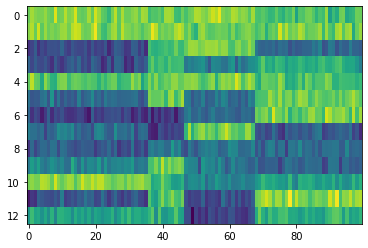

In [2]:
data_size = (13,100)
n_states = 4
data_array = models.gen_test_array(data_size, n_states, type = 'normal')
plt.imshow(data_array, aspect='auto');

In [3]:
# Create and fit model
n_fit = 80000
n_samples = 20000
state_range = np.arange(2, 8+1)

best_model, model_list, elbo_values = \
    models.find_best_states(
            data_array, 
            models.gaussian_changepoint_2d,
            n_fit,
            n_samples,
            min_states = state_range.min(),
            max_states = state_range.max()
)

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting model with 2 states


Finished [100%]: Average Loss = -274.72
 14%|█▍        | 1/7 [00:31<03:09, 31.54s/it]

Fitting model with 3 states


Finished [100%]: Average Loss = -534.22
 29%|██▊       | 2/7 [00:54<02:13, 26.62s/it]

Fitting model with 4 states


Finished [100%]: Average Loss = -648.2
 43%|████▎     | 3/7 [01:18<01:40, 25.20s/it]

Fitting model with 5 states


Finished [100%]: Average Loss = -604.1
 57%|█████▋    | 4/7 [01:43<01:15, 25.11s/it]

Fitting model with 6 states


Finished [100%]: Average Loss = -570.02
 71%|███████▏  | 5/7 [02:09<00:50, 25.46s/it]

Fitting model with 7 states


Finished [100%]: Average Loss = -530.54
 86%|████████▌ | 6/7 [02:35<00:25, 25.88s/it]

Fitting model with 8 states


Finished [100%]: Average Loss = -483.47
100%|██████████| 7/7 [03:03<00:00, 26.22s/it]


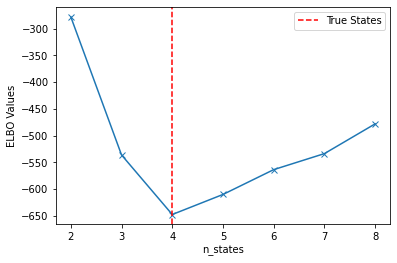

In [15]:
plt.plot(state_range, elbo_values, '-x')
plt.axvline(n_states, color = 'red', linestyle = '--', label = 'True States')
plt.xlabel('n_states')
plt.ylabel('ELBO Values')
plt.legend()

In [18]:
best_state_num = state_range[np.argmin(elbo_values)]
print(f'Best state num : {best_state_num}')

Best state num : 4


In [19]:
model = models.gaussian_changepoint_2d(data_array, best_state_num)
model, approx, mu_stack, sigma_stack, tau_samples, fit_data = \
        models.advi_fit(model = model, fit = n_fit, samples = n_samples)

Finished [100%]: Average Loss = -648.03


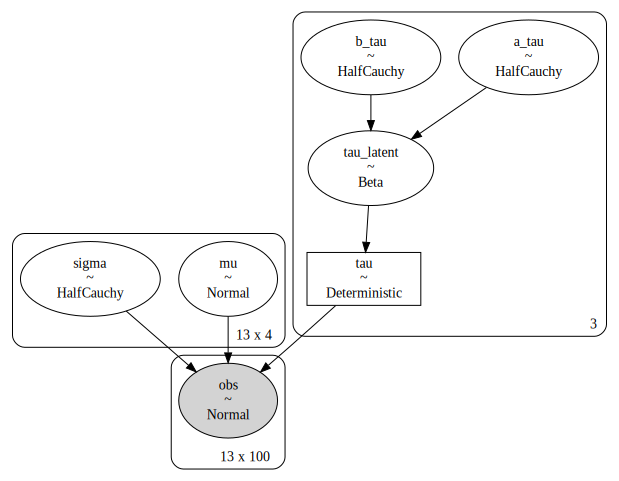

In [20]:
pm.model_to_graphviz(model)

In [21]:
# Extract changepoint values
int_tau = np.vectorize(np.int)(tau_samples)
mode_tau = np.squeeze(stats.mode(int_tau, axis=0)[0])

In [22]:
int_tau.shape

(20000, 3)

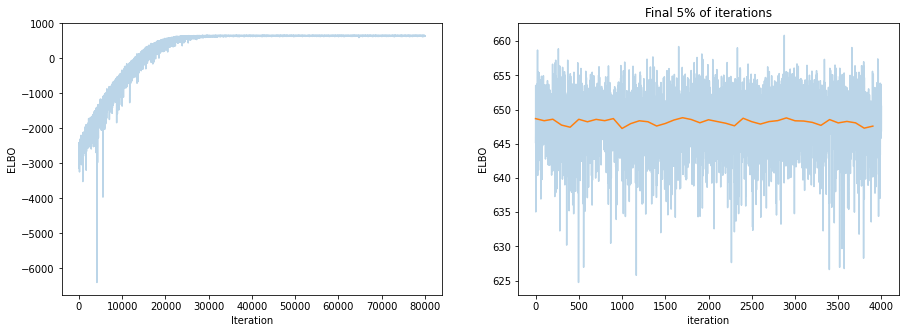

In [23]:
# Plot ELBO over iterations, should be flat by the end
fig, ax = plotting.plot_elbo_history(approx)
plt.show()

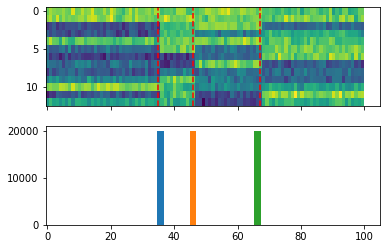

In [24]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].imshow(data_array, aspect='auto')
for val in mode_tau:
    ax[0].axvline(val, color = 'red', linestyle = '--')
for dist in int_tau.T:
    ax[1].hist(dist, bins = np.linspace(0,data_size[1],50))